In [1]:
import numpy as np
import scipy.stats as stats
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.decomposition import NMF, LatentDirichletAllocation, FactorAnalysis, PCA
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix
import sys
sys.path.append('../data_science')
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns



np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
import pandas as pd

### Latent Variable Models

Assume that we have n students and k courses. All students have grades for all courses. Factor analysis assumes that actually there are few parameters (latent variables) which determine students' grades. For example IQ and study_time might be the basic factors which determine the grades. 

Let us assume that there are 5 courses. We will assume that IQ scores and study times of the students determine the grades they get from these courses. In other words we can model the grade of a student $s$ for course $c$ as follows:

$$
grade_{sc} = IQ_s*F_c + ST_s*F_c
$$

$F_c$ is the factor for each course which together with IQ and studt time determines the grade. This is also reasonable to assume since otherwise a student would get the same grade from all courses.


In [2]:
n = 100
k = 5

# Students IQs normally distributed with mean = 100, std = 20
IQ = np.random.normal(100,20,n).reshape(n,-1)
ST = np.random.normal(10,2,n).reshape(n,-1)
IQST = np.hstack([IQ,ST])

# Course factors,  what do these values represent? why do we need them?
CF = np.random.rand(2,5)

print(CF)
print(IQST[:10])


[[0.12 0.66 0.75 0.63 0.28]
 [0.85 1.   0.2  0.66 0.45]]
[[ 91.9    7.84]
 [108.78  14.74]
 [103.72  11.45]
 [ 93.17   6.25]
 [105.8   10.67]
 [109.    12.97]
 [104.33  10.39]
 [117.15  10.63]
 [105.78   9.22]
 [ 79.55   9.11]]


In [3]:
GM = np.dot(IQST,CF)
GM[:10]

array([[17.77, 68.25, 70.28, 63.04, 29.01],
       [25.71, 86.23, 84.29, 78.22, 36.81],
       [22.29, 79.62, 79.85, 72.87, 33.92],
       [16.57, 67.5 , 70.91, 62.8 , 28.64],
       [21.87, 80.22, 81.25, 73.67, 34.14],
       [24.22, 84.62, 84.11, 77.2 , 36.07],
       [21.46, 78.97, 80.09, 72.56, 33.61],
       [23.21, 87.64, 89.73, 80.79, 37.27],
       [20.63, 78.75, 80.94, 72.7 , 33.48],
       [17.37, 61.4 , 61.31, 56.11, 26.16]])

In [4]:
pd.DataFrame(GM).corr()

,0,1,2,3,4
0,1.000000,0.906826,0.851114,0.887413,0.911474
1,0.906826,1.000000,0.993095,0.999033,0.999938
2,0.851114,0.993095,1.000000,0.997293,0.991723
3,0.887413,0.999033,0.997293,1.000000,0.998480
4,0.911474,0.999938,0.991723,0.998480,1.000000


<Axes: >

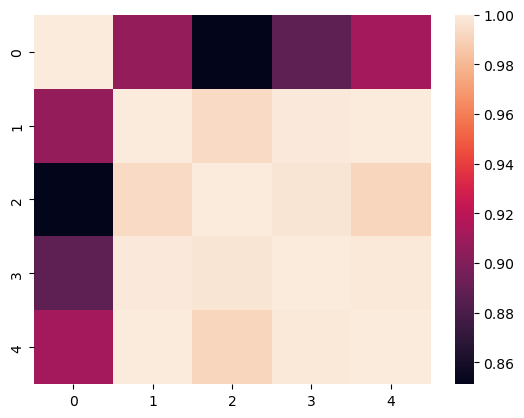

In [5]:
sns.heatmap(pd.DataFrame(GM).corr())

### Factor Analysis

In [6]:
fa = FactorAnalysis(n_components=2).fit(GM)

In [7]:
L = fa.components_
print(L)
F = fa.transform(GM)
print(F[:10])

[[ -2.71 -13.66 -15.24 -12.99  -5.76]
 [  1.43   0.67  -1.04   0.07   0.35]]
[[ 0.51 -1.03]
 [-0.64  2.34]
 [-0.24  0.71]
 [ 0.52 -1.85]
 [-0.3   0.3 ]
 [-0.57  1.44]
 [-0.22  0.17]
 [-0.85  0.19]
 [-0.23 -0.44]
 [ 1.04 -0.29]]


In [8]:
GM_recovered = fa.mean_ + np.dot(F,L)
GM_recovered[:10]

array([[17.77, 68.25, 70.28, 63.04, 29.01],
       [25.71, 86.23, 84.29, 78.22, 36.81],
       [22.29, 79.62, 79.85, 72.87, 33.92],
       [16.57, 67.5 , 70.91, 62.8 , 28.64],
       [21.87, 80.22, 81.25, 73.67, 34.14],
       [24.22, 84.62, 84.11, 77.2 , 36.07],
       [21.46, 78.97, 80.09, 72.56, 33.61],
       [23.21, 87.64, 89.73, 80.79, 37.27],
       [20.63, 78.75, 80.94, 72.7 , 33.48],
       [17.37, 61.4 , 61.31, 56.11, 26.16]])

In [9]:
GM[:10]

array([[17.77, 68.25, 70.28, 63.04, 29.01],
       [25.71, 86.23, 84.29, 78.22, 36.81],
       [22.29, 79.62, 79.85, 72.87, 33.92],
       [16.57, 67.5 , 70.91, 62.8 , 28.64],
       [21.87, 80.22, 81.25, 73.67, 34.14],
       [24.22, 84.62, 84.11, 77.2 , 36.07],
       [21.46, 78.97, 80.09, 72.56, 33.61],
       [23.21, 87.64, 89.73, 80.79, 37.27],
       [20.63, 78.75, 80.94, 72.7 , 33.48],
       [17.37, 61.4 , 61.31, 56.11, 26.16]])

### Nonnegative Matrix Factorization

In [19]:
from scipy.sparse import csr_matrix


# Create a dense matrix
dense_matrix = np.array([[0, 0, 0, 0],
                        [0, 5, 0, 0],
                        [0, 0, 0, 8]])

# Convert the dense matrix to a sparse matrix
sparse_matrix = csr_matrix(dense_matrix)

print(sparse_matrix)
GM = sparse_matrix

  (1, 1)	5
  (2, 3)	8


In [15]:
from sklearn.decomposition import TruncatedSVD

In [21]:
tsvd = NMF(n_components=2).fit(GM)
W = tsvd.transform(GM)
H = tsvd.components_
print(W[:10])
print(H)

[[0.   0.  ]
 [0.   1.31]
 [1.23 0.  ]]
[[0.   0.   0.   6.52]
 [0.   3.81 0.   0.  ]]


In [14]:
nmf = NMF(n_components=2).fit(GM)
W = nmf.transform(GM)
H = nmf.components_
print(W[:10])
print(H)

ValueError: Input X contains NaN.
NMF does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [11]:
GM_recovered = np.dot(W,H)
GM_recovered[:10]

array([[19.64, 69.07, 68.83, 63.07, 29.44],
       [24.75, 85.83, 85.06, 78.22, 36.6 ],
       [22.94, 79.91, 79.34, 72.88, 34.07],
       [19.4 , 68.74, 68.71, 62.84, 29.29],
       [23.1 , 80.76, 80.3 , 73.69, 34.43],
       [24.4 , 84.69, 83.97, 77.2 , 36.11],
       [22.74, 79.54, 79.09, 72.57, 33.9 ],
       [25.23, 88.53, 88.15, 80.82, 37.73],
       [22.66, 79.65, 79.36, 72.72, 33.95],
       [17.7 , 61.54, 61.06, 56.11, 26.24]])

# Missing Value
Suppose that one of the values in the GM matrix is missing. Can we find/recover it? Unfortunately FA and NMF will not work if there are missing values in the dataset.

In [12]:
GM[0,0] = np.nan
GM[:10]

array([[  nan, 68.25, 70.28, 63.04, 29.01],
       [25.71, 86.23, 84.29, 78.22, 36.81],
       [22.29, 79.62, 79.85, 72.87, 33.92],
       [16.57, 67.5 , 70.91, 62.8 , 28.64],
       [21.87, 80.22, 81.25, 73.67, 34.14],
       [24.22, 84.62, 84.11, 77.2 , 36.07],
       [21.46, 78.97, 80.09, 72.56, 33.61],
       [23.21, 87.64, 89.73, 80.79, 37.27],
       [20.63, 78.75, 80.94, 72.7 , 33.48],
       [17.37, 61.4 , 61.31, 56.11, 26.16]])

In [13]:
fa = FactorAnalysis(n_components=2).fit(GM)

ValueError: Input X contains NaN.
FactorAnalysis does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### First Solution

One solution might be to set missing values to zero. This might work when there are a few missing values, but if most of the data is missing such as the case in rec. sys. this will not work

In [ ]:
GM[0,0] = 0
L = fa.components_
F = fa.transform(GM)
GM_recovered = fa.mean_ + np.dot(F,L)
GM_recovered[:10]

array([[ 49.28,  41.43,  36.58,  92.68,  68.1 ],
       [ 75.32,  65.55,  60.62, 116.05,  97.09],
       [ 69.5 ,  60.38,  55.72, 108.22,  89.9 ],
       [ 54.5 ,  47.45,  43.91,  83.71,  70.18],
       [ 68.37,  59.91,  55.88, 100.7 ,  86.86],
       [ 39.13,  34.86,  33.18,  51.1 ,  47.93],
       [ 50.35,  44.  ,  40.91,  75.45,  64.32],
       [ 75.33,  65.72,  60.96, 114.23,  96.6 ],
       [ 57.01,  49.84,  46.36,  85.19,  72.76],
       [ 52.08,  45.92,  43.18,  73.32,  65.24]])

In [ ]:
nmf = NMF(n_components=2)
nmf.fit(GM)
W = nmf.transform(GM)
H = nmf.components_
GM_recovered = np.dot(W,H)
GM_recovered[:10]


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


array([[  0.68,  56.5 ,  52.5 ,  97.26,  82.72],
       [ 75.37,  66.27,  61.49, 114.96,  97.33],
       [ 69.55,  61.45,  57.02, 106.6 ,  90.25],
       [ 54.53,  47.88,  44.43,  83.06,  70.32],
       [ 68.37,  58.91,  54.66, 102.22,  86.53],
       [ 38.07,  32.14,  29.82,  55.78,  47.22],
       [ 50.36,  43.73,  40.57,  75.86,  64.23],
       [ 75.36,  65.78,  61.04, 114.13,  96.62],
       [ 57.02,  49.45,  45.88,  85.79,  72.63],
       [ 52.04,  43.97,  40.8 ,  76.3 ,  64.59]])

### MF with SGD

In [ ]:
GM[0,0]=55.76

In [ ]:
x = GM.shape[0]
y = GM.shape[1] 
c1 = []
c2 = []
c3 = []
for i in range(x):
    for j in range(y):
        c1.append(i)
        c2.append(j)
        c3.append(GM[i,j])
SM = pd.DataFrame({"StudentID":c1,"CourseID":c2,"Grade":c3})
SM

,StudentID,CourseID,Grade
0,0,0,55.760000
1,0,1,21.990644
2,0,2,62.966582
3,0,3,50.074894
4,0,4,98.211788
...,...,...,...
495,99,0,45.941515
496,99,1,18.300759
497,99,2,52.000967
498,99,3,41.317004


In [ ]:
type(SM)

pandas.core.frame.DataFrame

In [ ]:
#SM.drop(0, axis=0, inplace=True)
#SM.drop(5, axis=0, inplace=True)
SM

,StudentID,CourseID,Grade
1,0,1,21.990644
2,0,2,62.966582
3,0,3,50.074894
4,0,4,98.211788
6,1,1,26.082312
...,...,...,...
495,99,0,45.941515
496,99,1,18.300759
497,99,2,52.000967
498,99,3,41.317004


In [ ]:
class MF:
    """
    prefs: matrix of prefences, column0=userid, column1=itemid, column2=pref, column3=timestamp 
    """
    def __init__(self, prefs, alpha=0.03, mylambda=0.1, n_factors = 10, n_iters = 50):
        self.alpha = alpha
        self.mylambda = mylambda
        self.n_iters = n_iters
        self.item_factors = {}
        self.user_factors = {}
        self.prefs = prefs
        # prefs is a matrix containing u, i, r values in each row. This is useful to shuffle and pass over
        # the data multiple times in an efficient way in the fit() method.
        for r in range(self.prefs.shape[0]):
            self.user_factors[self.prefs.iloc[r,0]] = np.random.rand(n_factors,1) - 0.5
            self.item_factors[self.prefs.iloc[r,1]] = np.random.rand(n_factors,1) - 0.5
        print("Finished initialization")
        
     
    def calc_error(self, X):
        error = 0
        for i in range(X.shape[0]):
            u_idx = X.iloc[i,0]
            i_idx = X.iloc[i,1]
            error += np.abs(X.iloc[i,2] - np.dot(self.user_factors[u_idx].T, self.item_factors[i_idx])[0,0])
        return error/X.shape[0]

        #print("Random Predictor Error:",error/self.prefs.shape[0])
        
    def fit(self, verbose=False, method="SGD"):
        if (method == "Random"):
            error = 0
            for i in range(self.prefs.shape[0]):
                u_idx = self.prefs.iloc[i,0]
                i_idx = self.prefs.iloc[i,1]
                error += np.abs(self.prefs.iloc[i,2] - np.random.randint(1,6))
            return error/self.prefs.shape[0]
            
        elif (method == "SGD"):
            if (verbose): 
                print("Initial error: ", self.calc_error(self.prefs))                      
            for t in range(self.n_iters):
                self.prefs = shuffle(self.prefs)
                for r in range(self.prefs.shape[0]):
                    u = self.prefs.iloc[r,0]
                    i = self.prefs.iloc[r,1]
                    error = self.prefs.iloc[r,2] - np.dot(self.user_factors[u].T, self.item_factors[i])[0,0]
                    self.user_factors[u] = self.user_factors[u] + self.alpha*(error*self.item_factors[i] - self.mylambda*self.user_factors[u])
                    self.item_factors[i] = self.item_factors[i] + self.alpha*(error*self.user_factors[u] - self.mylambda*self.item_factors[i])  
            
                if (verbose): 
                    print("Iteration: ", t)
                if (verbose): 
                    print("Train error: ", self.calc_error(self.prefs))                      


In [ ]:
mf = MF(SM, alpha=0.001, n_factors = 2, n_iters=10)
mf.fit(verbose=True, method="SGD")

Finished initialization
Initial error:  60.4517443718097
Iteration:  0
Train error:  60.27592288091602
Iteration:  1
Train error:  54.61240627132645
Iteration:  2
Train error:  10.635146916690193
Iteration:  3
Train error:  1.848122358830091
Iteration:  4
Train error:  0.6878087949155195
Iteration:  5
Train error:  0.6012313183052593
Iteration:  6
Train error:  0.5870216287402713
Iteration:  7
Train error:  0.5916019070473849
Iteration:  8
Train error:  0.5767262445010647
Iteration:  9
Train error:  0.5778563422559425


In [ ]:
U = pd.DataFrame()
for i in range(n):
  U = U.append(pd.DataFrame(mf.user_factors[i].T))
U

,0,1
0,2.146853,3.103266
0,2.532797,4.204564
0,1.041344,1.974205
0,2.184998,2.894017
0,2.481380,3.936584
...,...,...
0,2.870054,4.060552
0,2.188613,3.762690
0,1.838249,3.164169
0,1.545526,2.240398


In [ ]:
I = pd.DataFrame()
for i in range(k):
  I = I.append(pd.DataFrame(mf.item_factors[i].T))
I

,0,1
0,8.167605,12.448705
0,3.174607,4.703543
0,9.456484,13.762311
0,6.683215,11.521709
0,13.465758,22.159386


In [ ]:
GM_recovered = np.dot(U,I.T)[:10]
GM_recovered

array([[ 56.17,  21.41,  63.01,  50.1 ,  97.68],
       [ 73.03,  27.82,  81.82,  65.37, 127.28],
       [ 33.08,  12.59,  37.02,  29.71,  57.77],
       [ 53.87,  20.55,  60.49,  47.95,  93.55],
       [ 69.27,  26.39,  77.64,  61.94, 120.65],
       [ 61.81,  23.58,  69.44,  54.95, 107.26],
       [ 35.57,  13.58,  40.01,  31.52,  61.61],
       [ 50.81,  19.32,  56.76,  45.81,  88.96],
       [ 41.75,  15.9 ,  46.74,  37.44,  72.85],
       [ 60.25,  22.96,  67.57,  53.8 , 104.85]])

In [ ]:
GM[:10]

array([[ 55.76,  21.99,  62.97,  50.07,  98.21],
       [ 75.57,  26.08,  82.78,  66.58, 126.88],
       [ 32.17,  13.58,  36.94,  29.19,  58.15],
       [ 54.19,  20.32,  60.47,  48.3 ,  93.68],
       [ 69.73,  26.23,  77.87,  62.18, 120.69],
       [ 61.72,  23.86,  69.36,  55.26, 107.9 ],
       [ 34.84,  14.07,  39.57,  31.4 ,  61.92],
       [ 51.23,  19.47,  57.34,  45.75,  89.  ],
       [ 41.19,  16.89,  46.95,  37.21,  73.62],
       [ 59.97,  23.44,  67.57,  53.78, 105.26]])